In [1]:
import pandas as pd
from pathlib import Path

DATA_PATH = Path("../anki-revlogs-10k")
user_id = 4

df_revlogs = pd.read_parquet(
    DATA_PATH / "revlogs", filters=[("user_id", "=", user_id)]
)
df_revlogs["review_th"] = range(1, df_revlogs.shape[0] + 1)
df_revlogs.drop(columns=["user_id"], inplace=True)

In [2]:
from itertools import accumulate

def preprocess_revlog(df):
    df["review_time"] = df["review_th"]
    df.sort_values(by=["card_id", "review_th"], inplace=True, ignore_index=True)
    df["delta_t"] = df["elapsed_days"]
    df["i"] = df.groupby("card_id").cumcount() + 1
    df.loc[df["i"] == 1, "delta_t"] = -1

    def cum_concat(x):
        return list(accumulate(x))

    t_history_list = df.groupby("card_id", group_keys=False)["delta_t"].apply(
        lambda x: cum_concat([[max(0, int(i))] for i in x])
    )
    df["t_history"] = [
        ",".join(map(str, item[:-1])) for sublist in t_history_list for item in sublist
    ]
    r_history_list = df.groupby("card_id", group_keys=False)["rating"].apply(
        lambda x: cum_concat([[i] for i in x])
    )
    df["r_history"] = [
        ",".join(map(str, item[:-1])) for sublist in r_history_list for item in sublist
    ]
    last_rating = []
    for t_sublist, r_sublist in zip(t_history_list, r_history_list):
        for t_history, r_history in zip(t_sublist, r_sublist):
            flag = True
            for t, r in zip(reversed(t_history[:-1]), reversed(r_history[:-1])):
                if t > 0:
                    last_rating.append(r)
                    flag = False
                    break
            if flag:
                last_rating.append(r_history[0])
    df["last_rating"] = last_rating
    df = df[
        (df["rating"] != 0)
        & (df["r_history"].str.contains("0") == 0)
        & (df["delta_t"] != 0)
    ].copy()

    df["i"] = df.groupby("card_id").cumcount() + 1
    df["first_rating"] = df["r_history"].map(lambda x: x[0] if len(x) > 0 else "")
    df["y"] = df["rating"].map(lambda x: {1: 0, 2: 1, 3: 1, 4: 1}[x])
    df = df[(df["i"] > 1) & (df["delta_t"] > 0)].copy()
    return df

dataset = preprocess_revlog(df_revlogs)
print(f"sample size: {dataset.shape[0]}")

sample size: 9187


In [3]:
from fsrs_optimizer import Optimizer

optimizer = Optimizer()
optimizer.define_model()
optimizer.pretrain(dataset=dataset, verbose=False)
optimizer.train(verbose=False)
loss_before, loss_after = optimizer.evaluate(save_to_file=False)
optimized_w = optimizer.w.copy()
print(f"loss_before: {loss_before}, loss_after: {loss_after}")

  0%|          | 0/9187 [00:00<?, ?it/s]

loss_before: 0.3900943869564932, loss_after: 0.3752441937057079


w_0: 0.7327


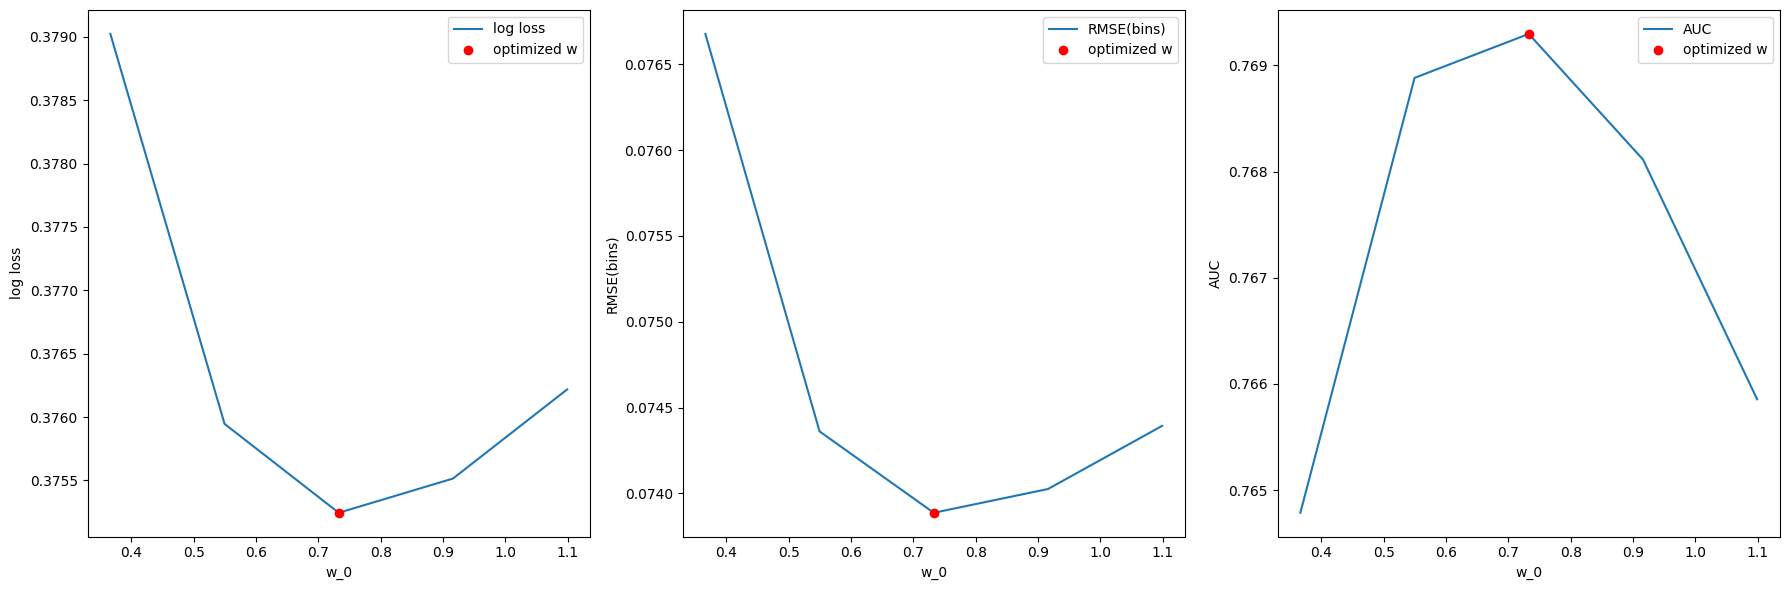

w_1: 3.1854


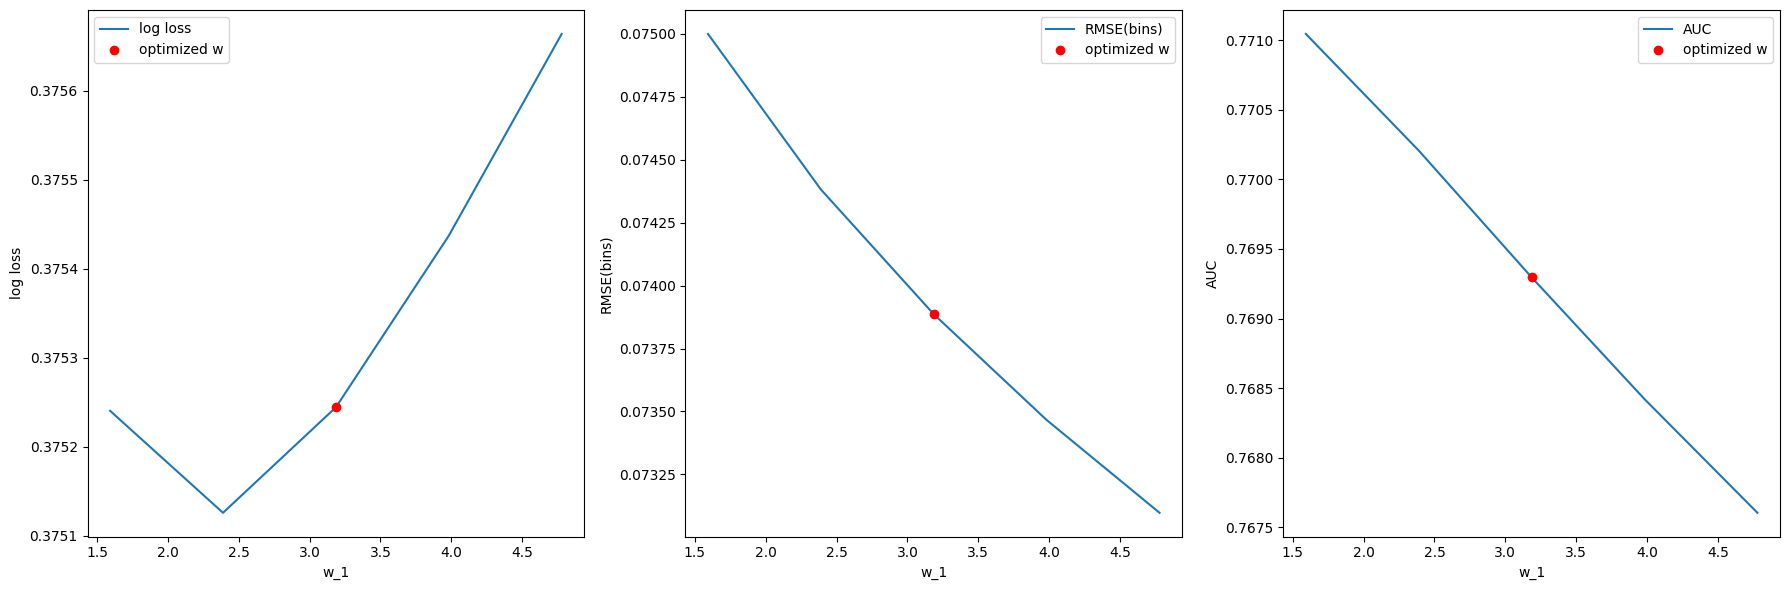

w_2: 4.0135


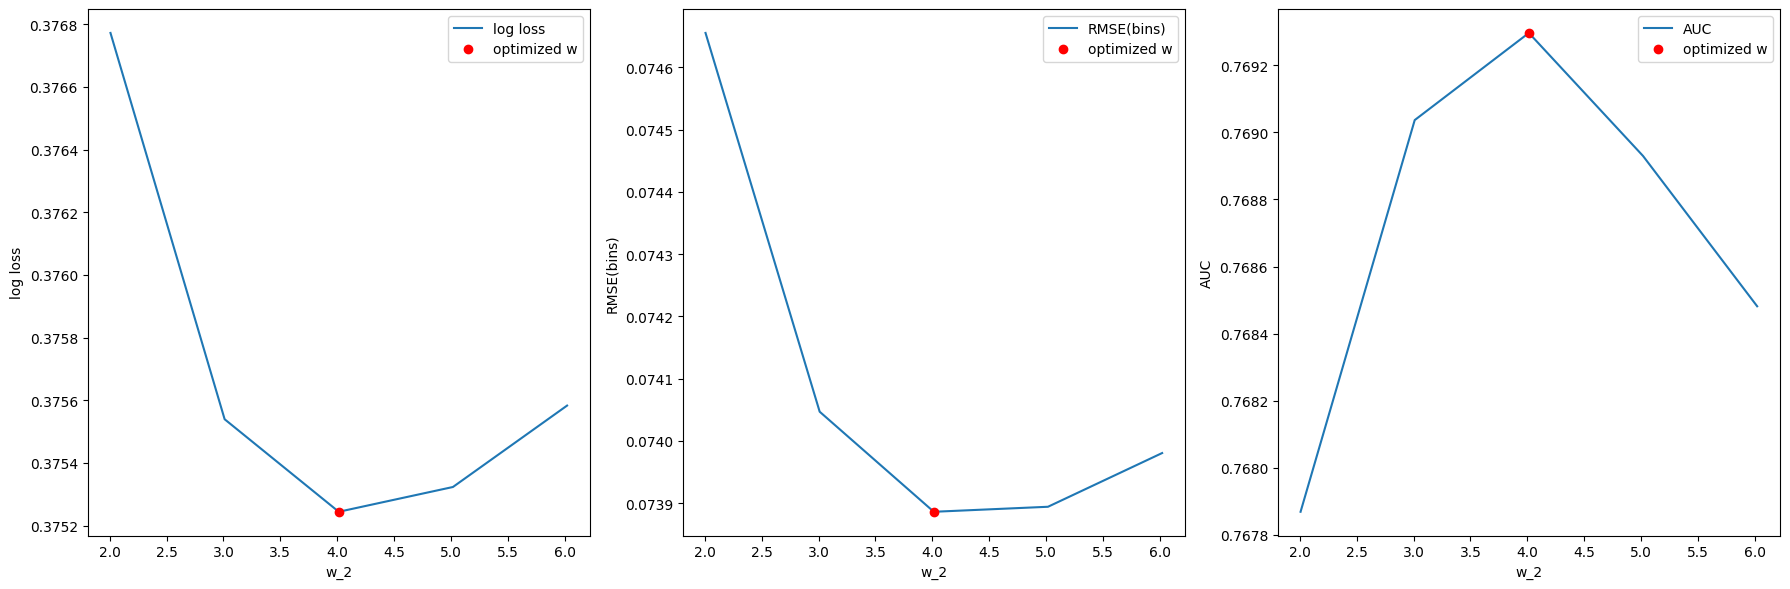

w_3: 11.7813


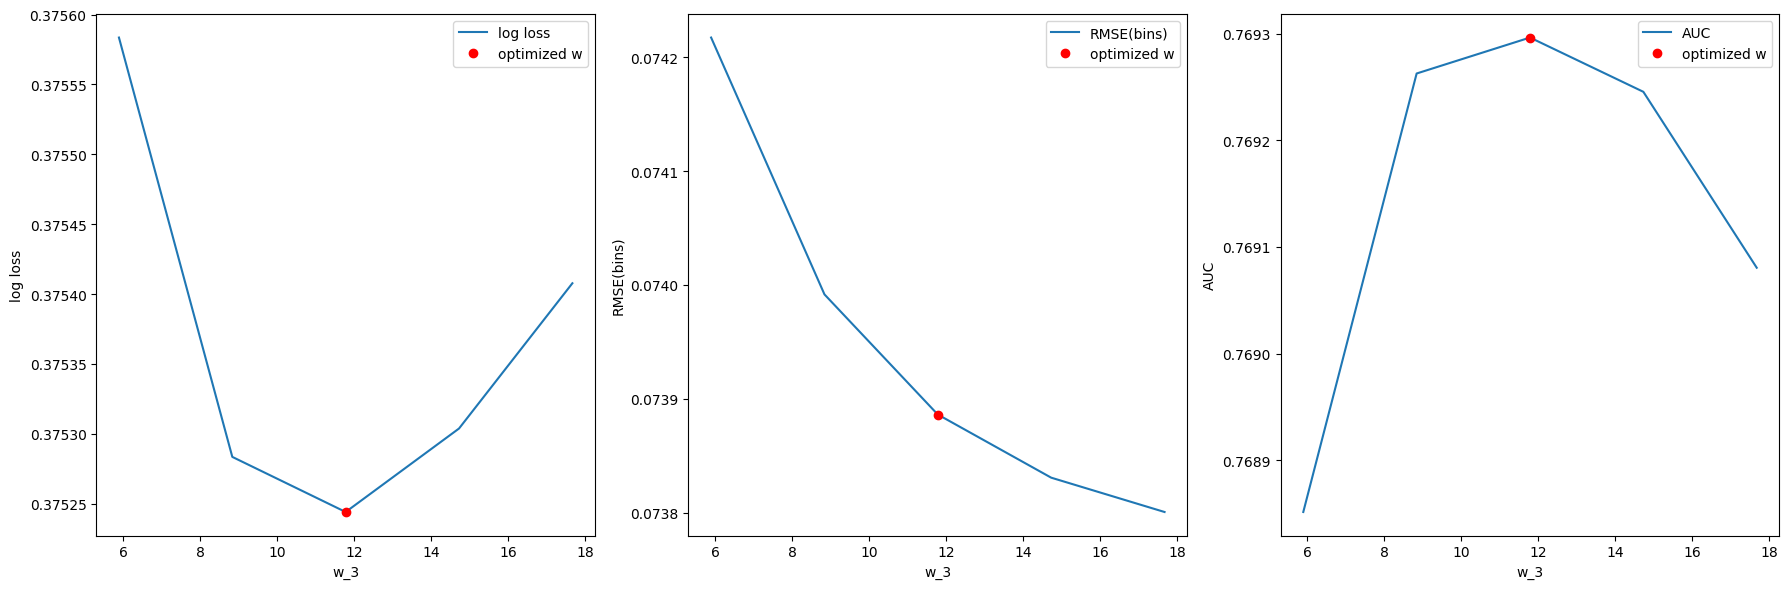

w_4: 7.3794


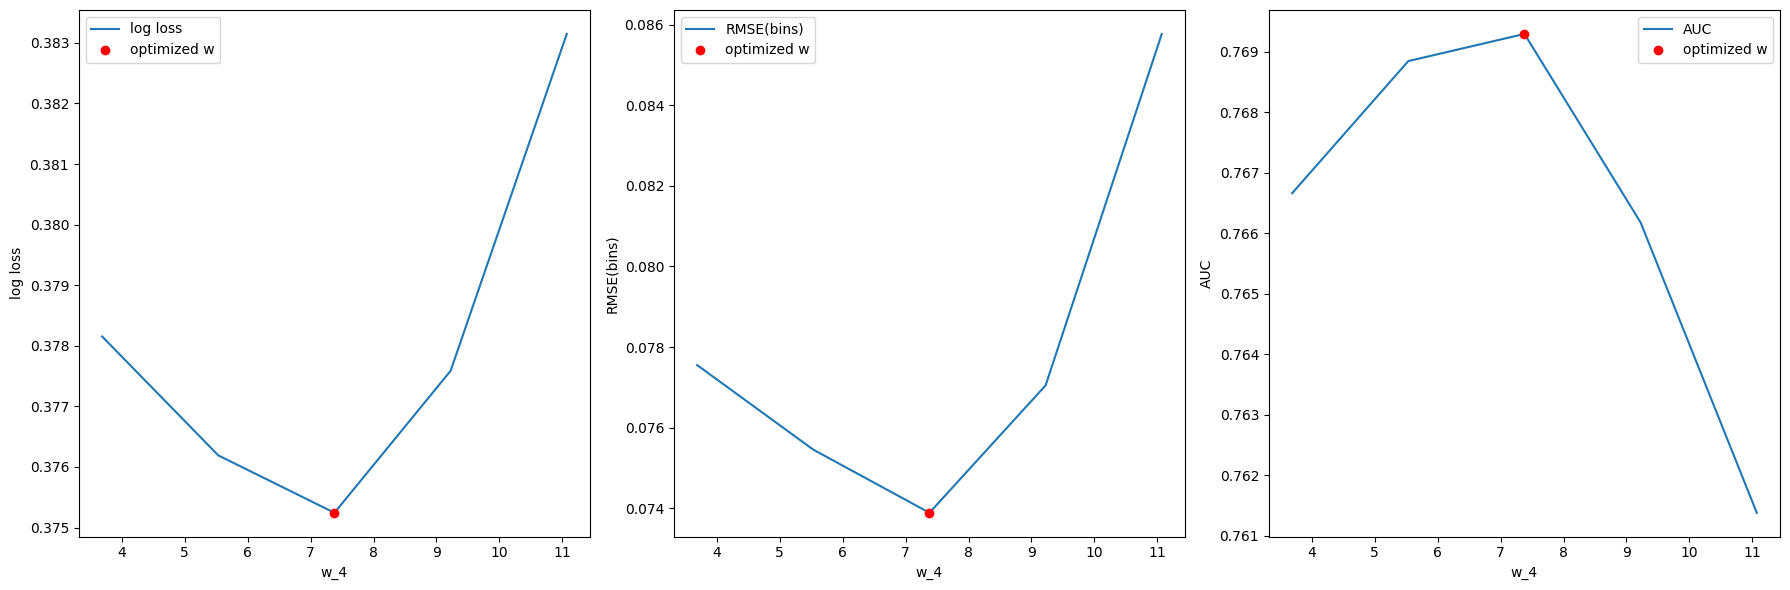

w_5: 0.8096


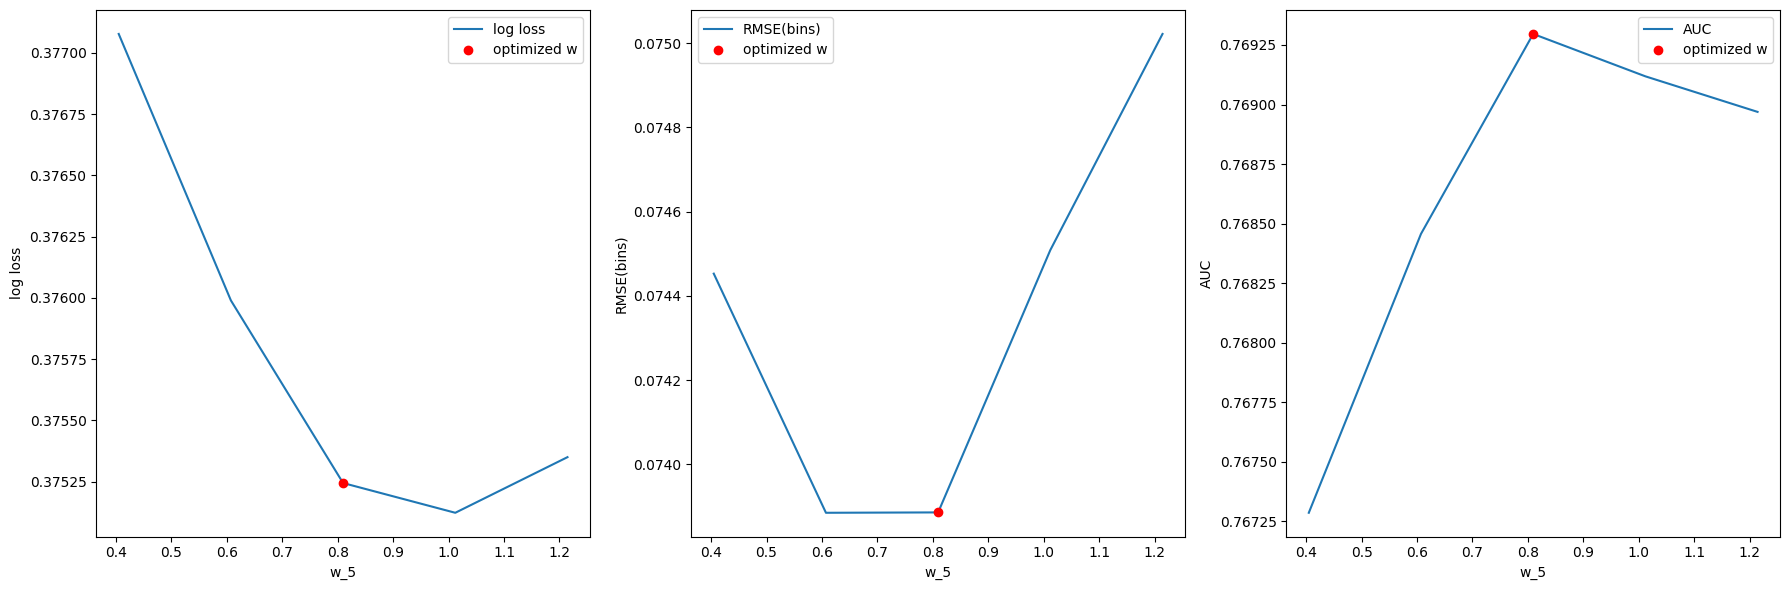

w_6: 2.1341


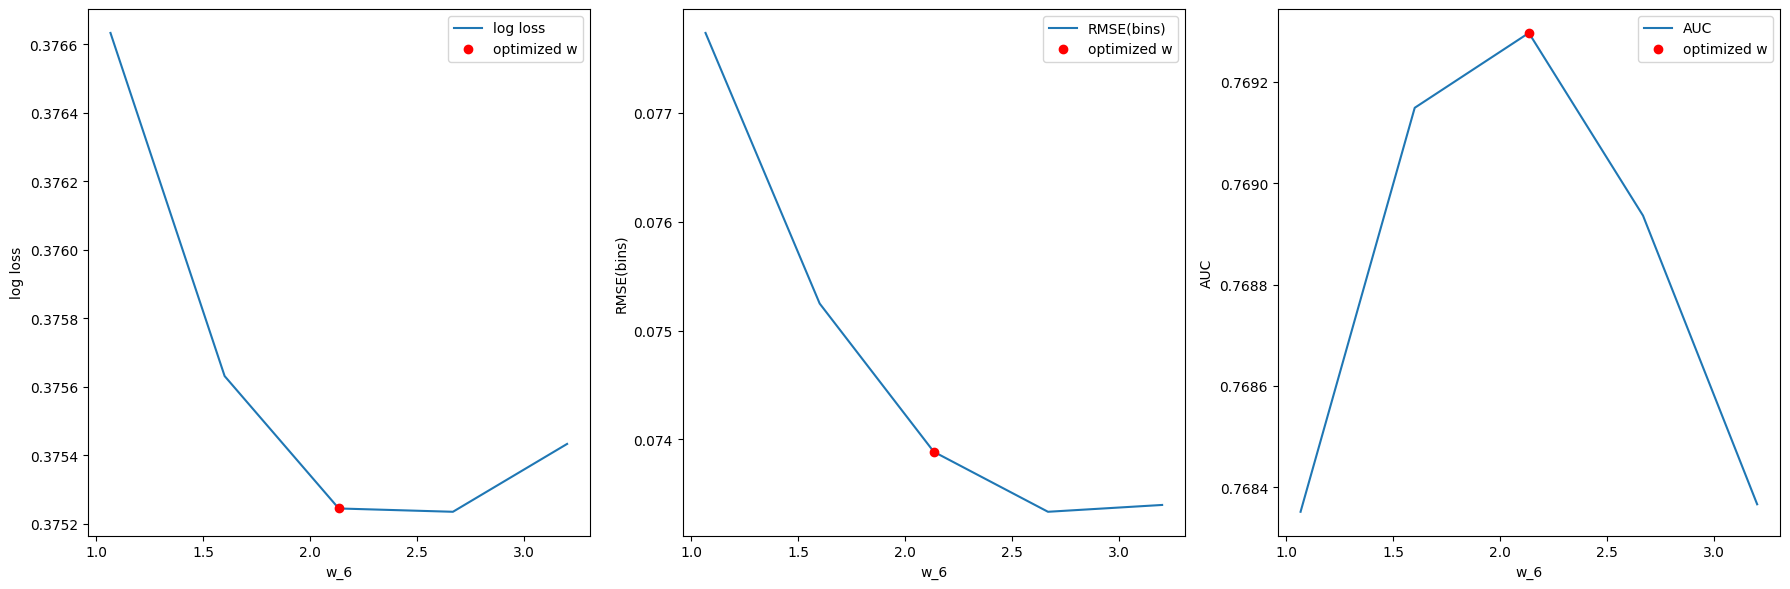

w_7: 0.001


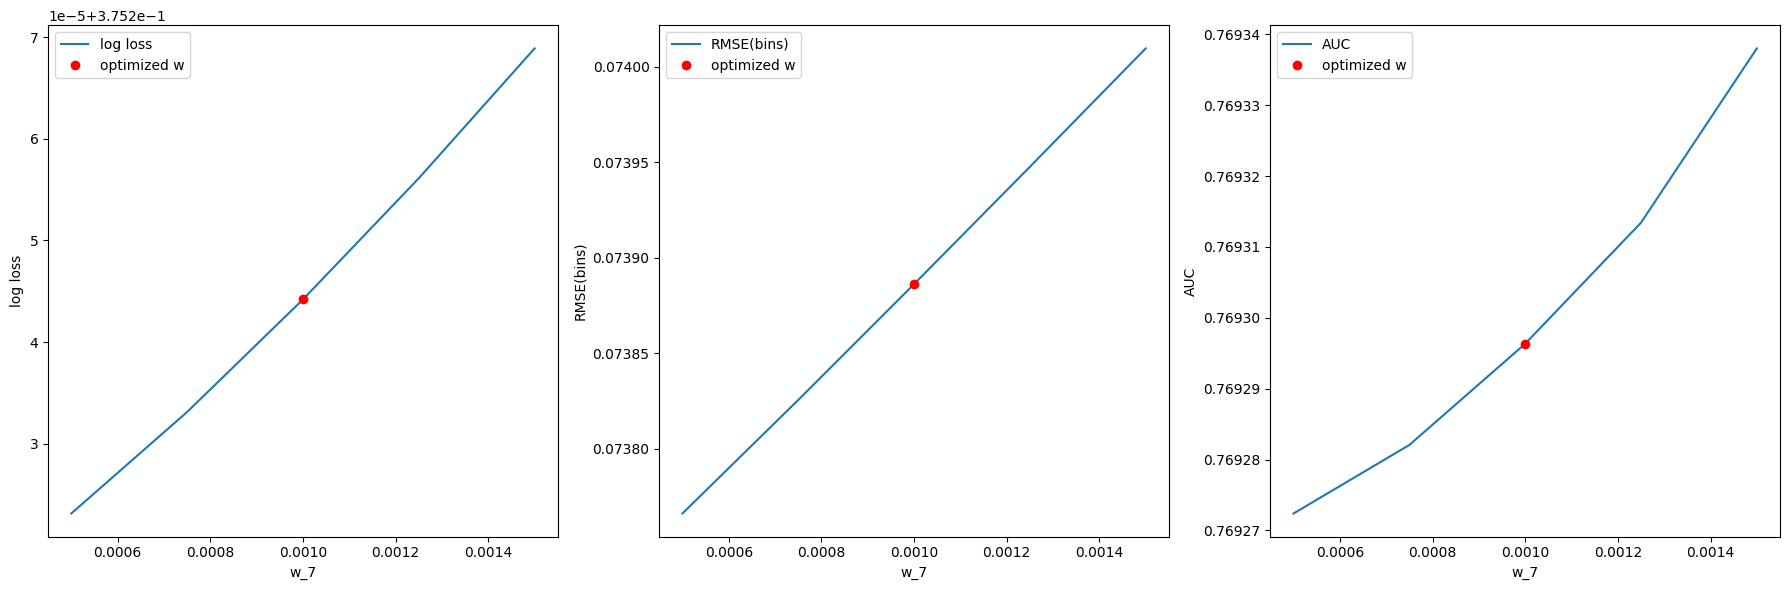

w_8: 1.2465


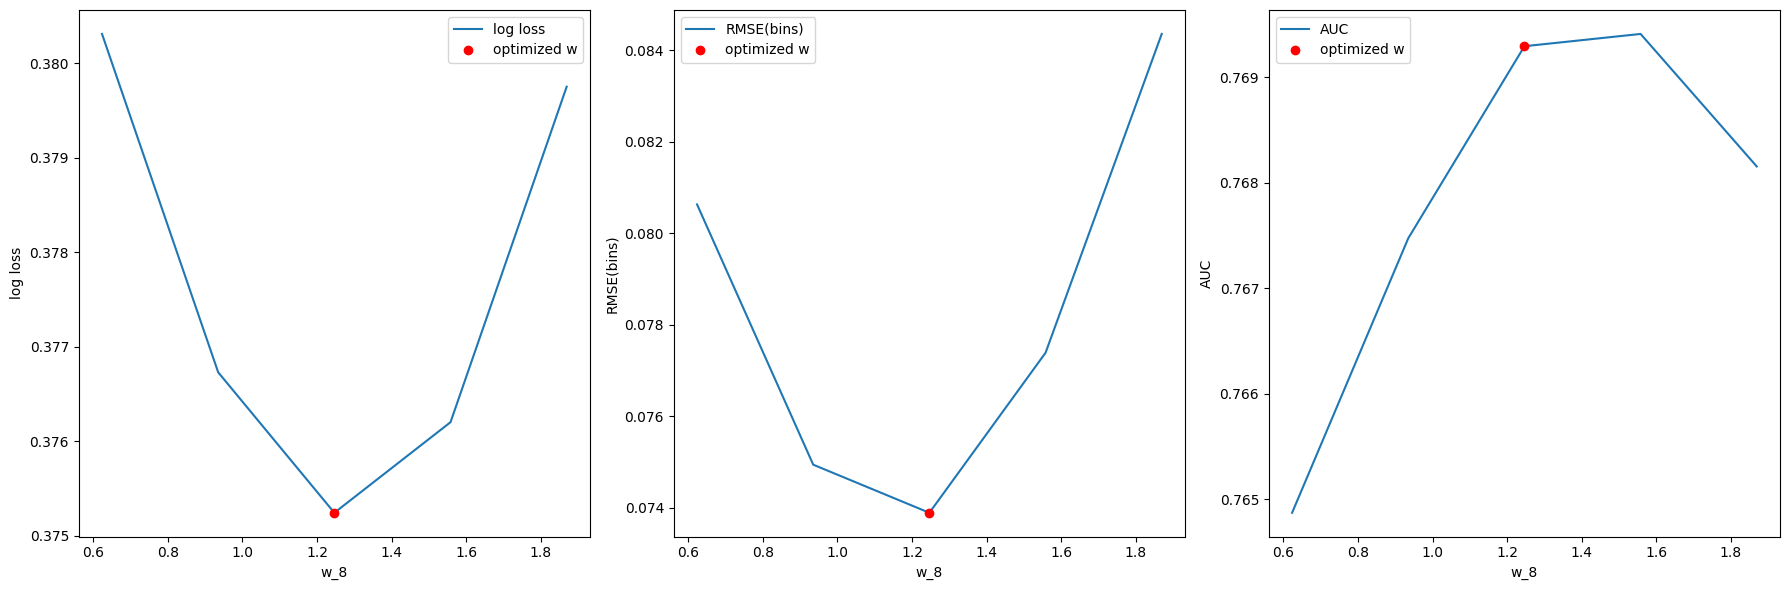

w_9: 0.2213


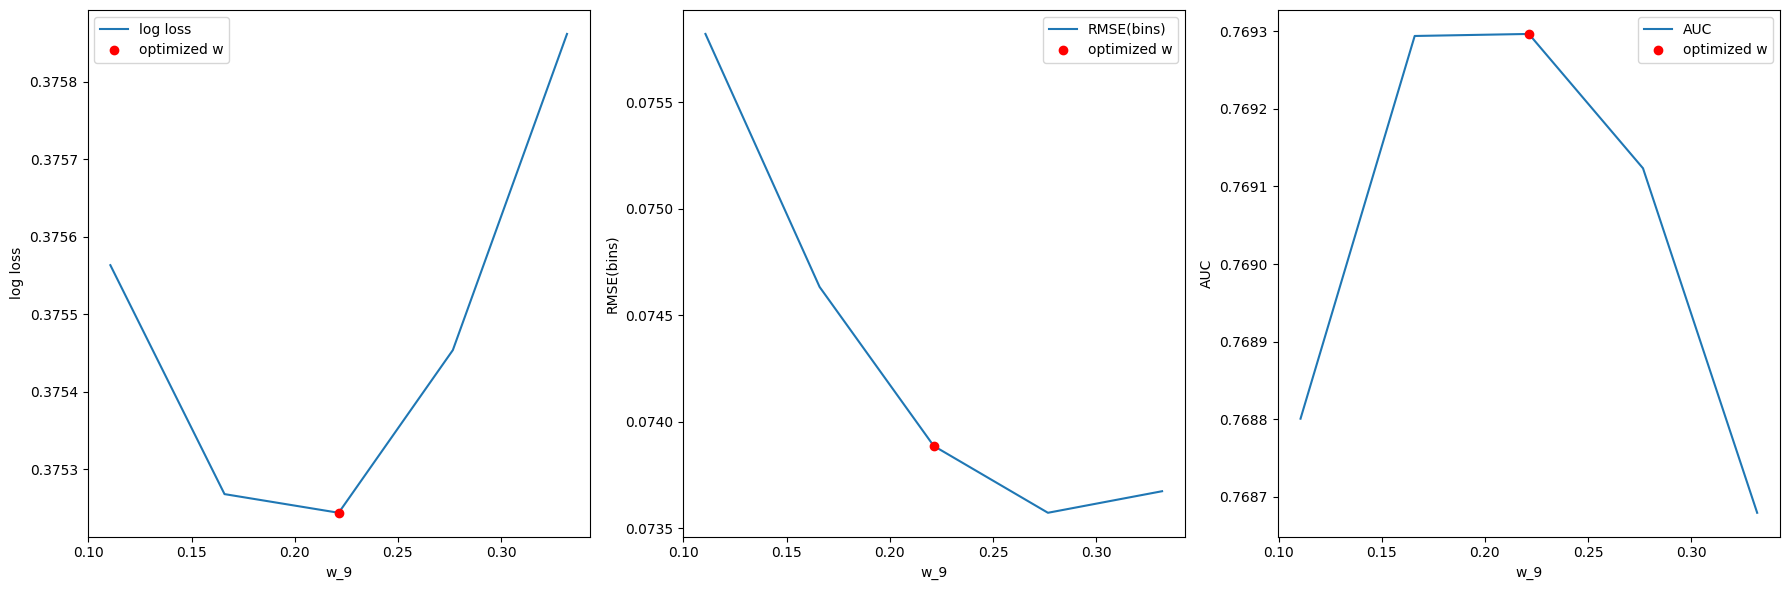

w_10: 0.7258


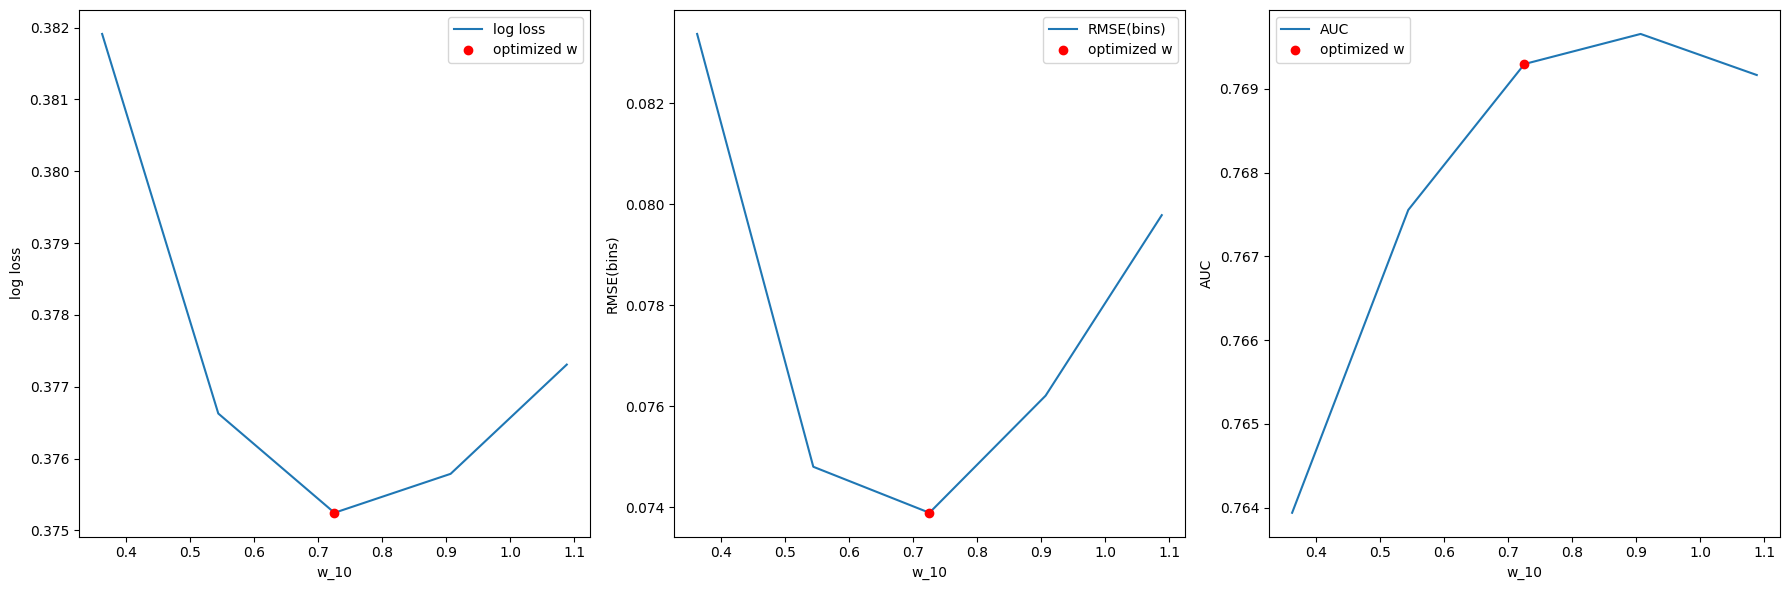

w_11: 1.9766


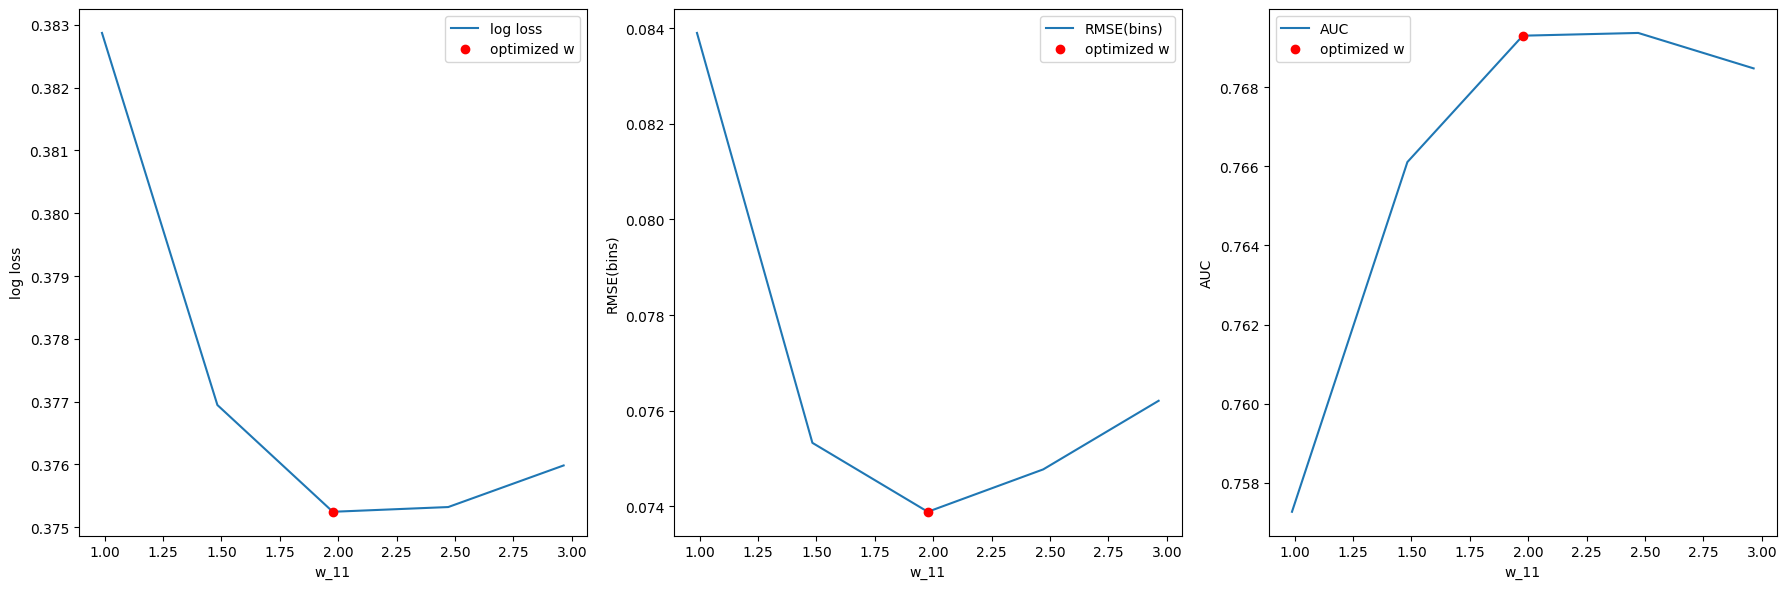

w_12: 0.0981


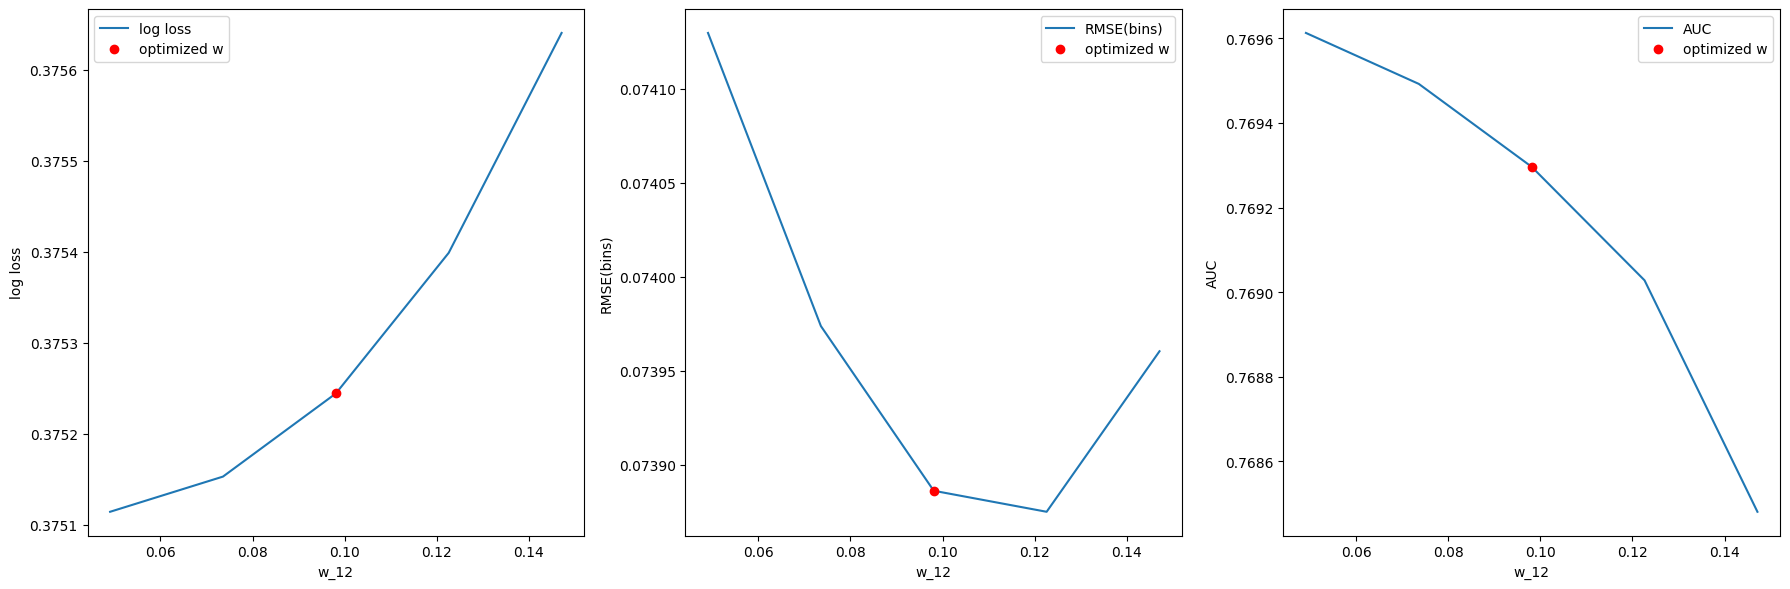

w_13: 0.4063


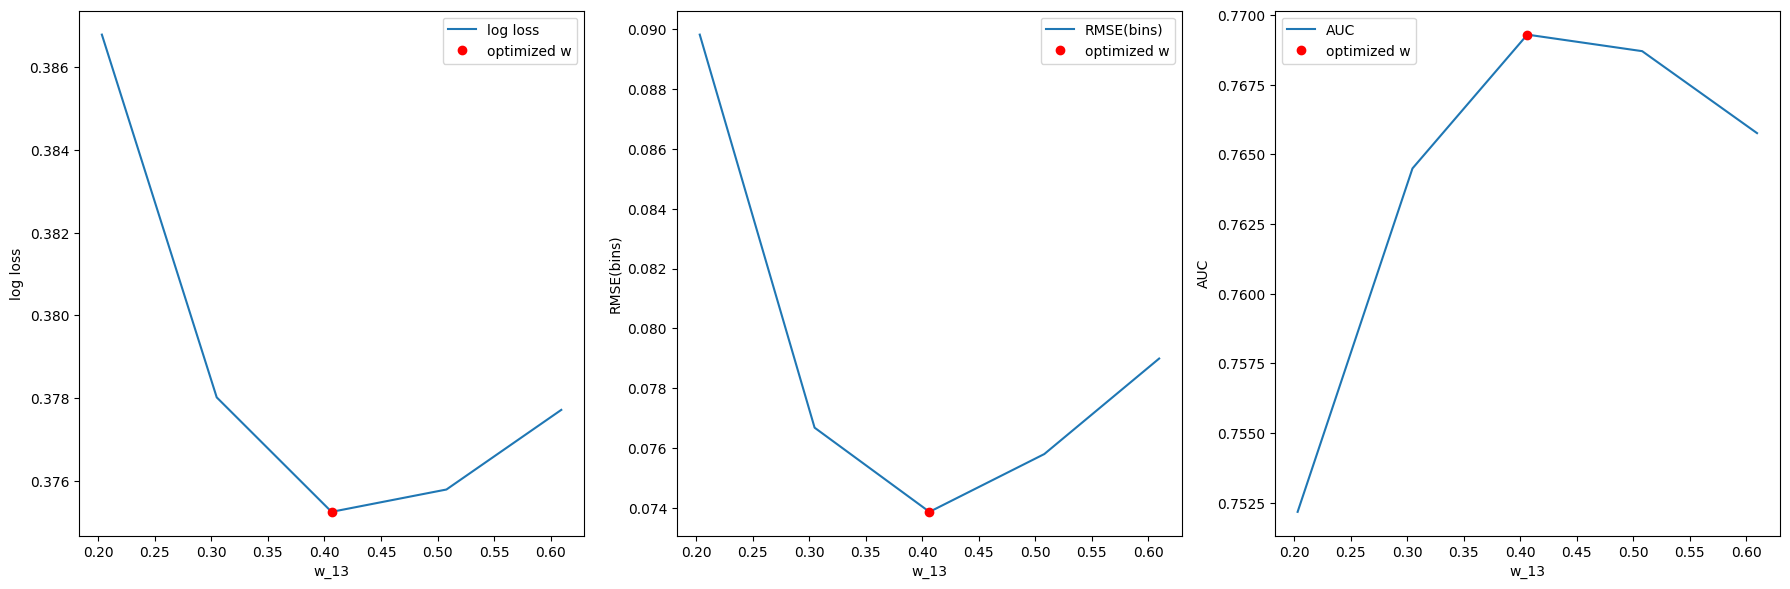

w_14: 2.239


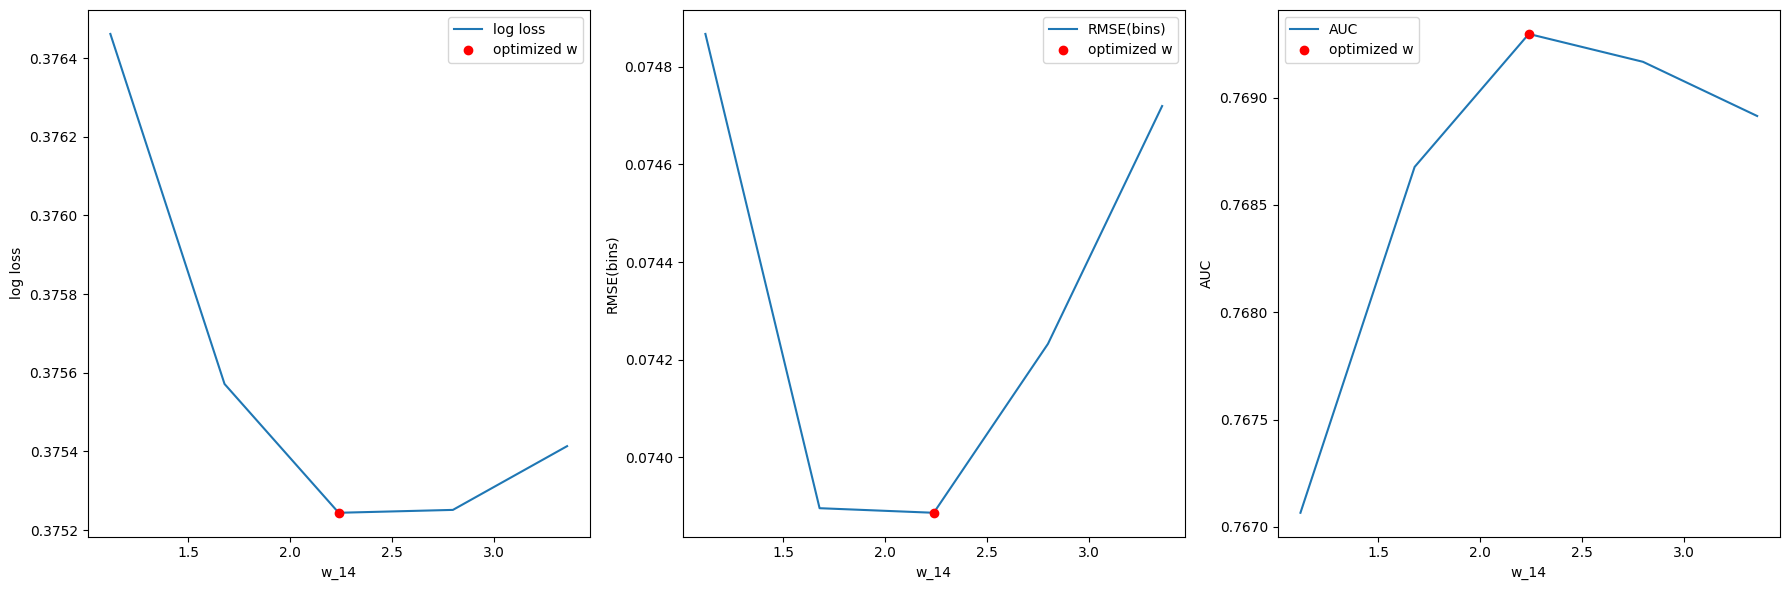

w_15: 0.0272


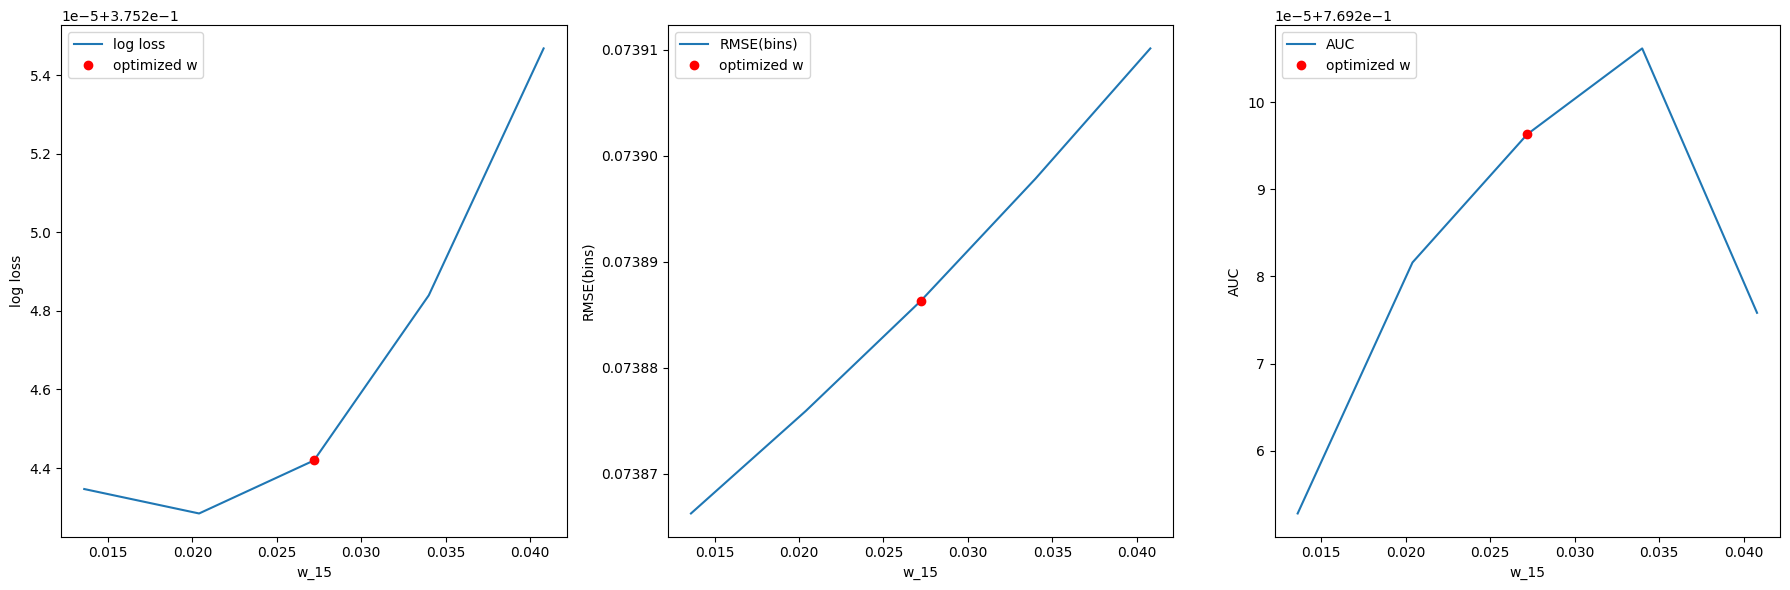

w_16: 3.0564


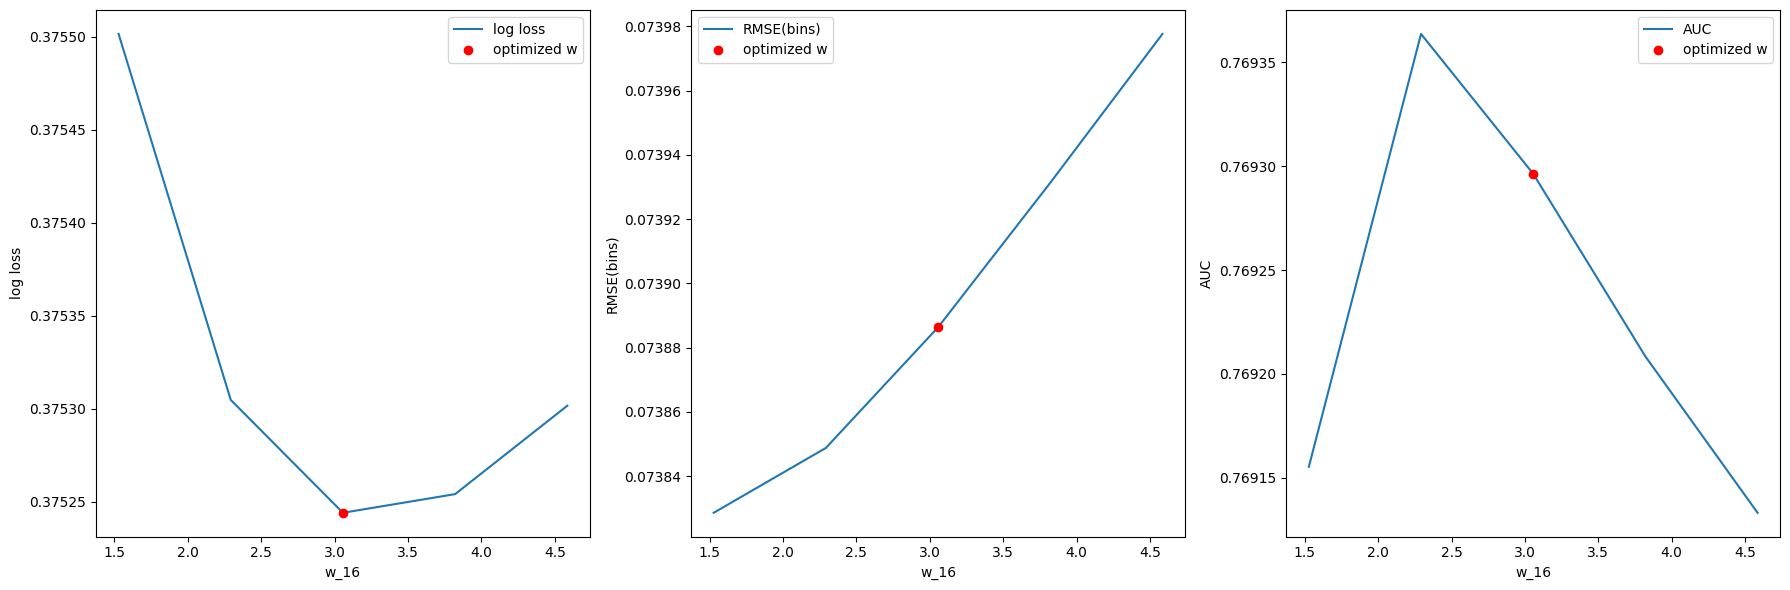

w_17: 0.2774


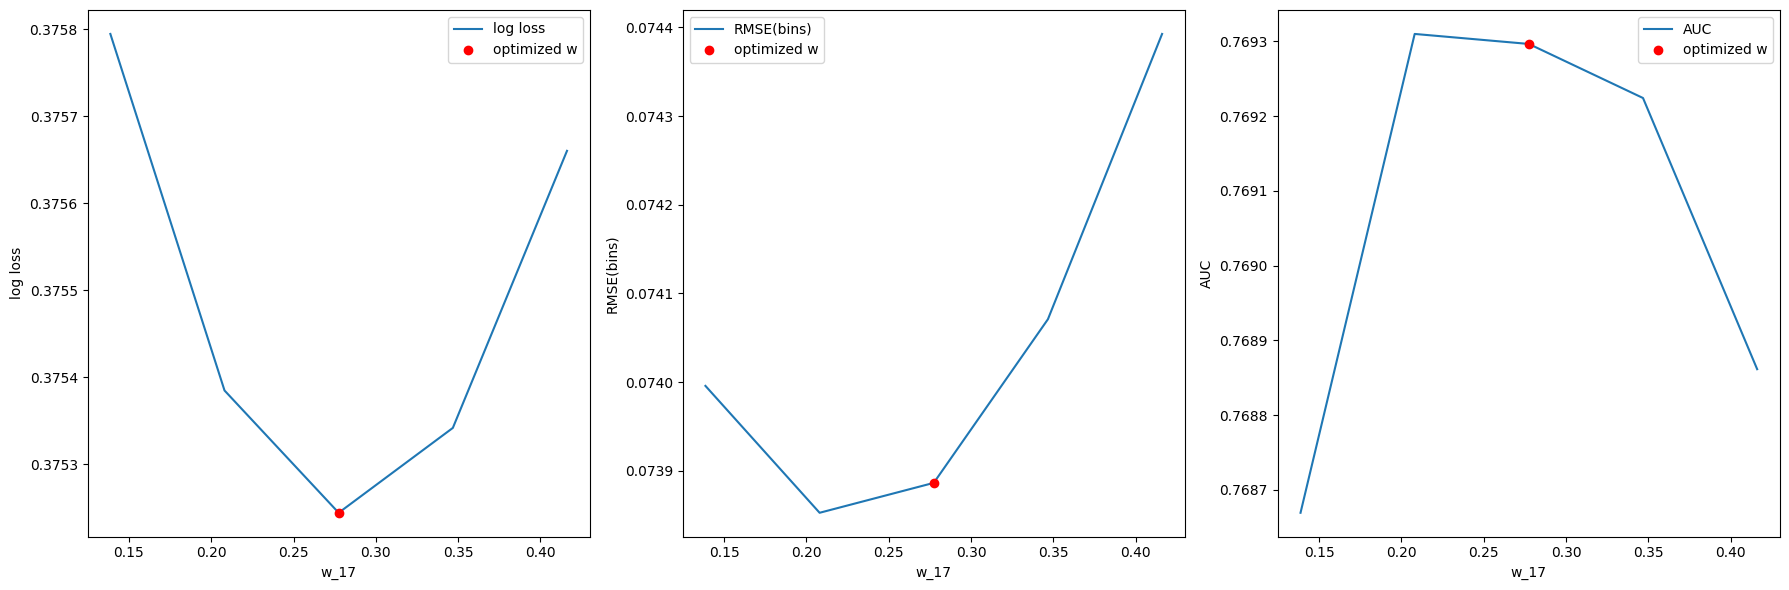

w_18: 0.7289


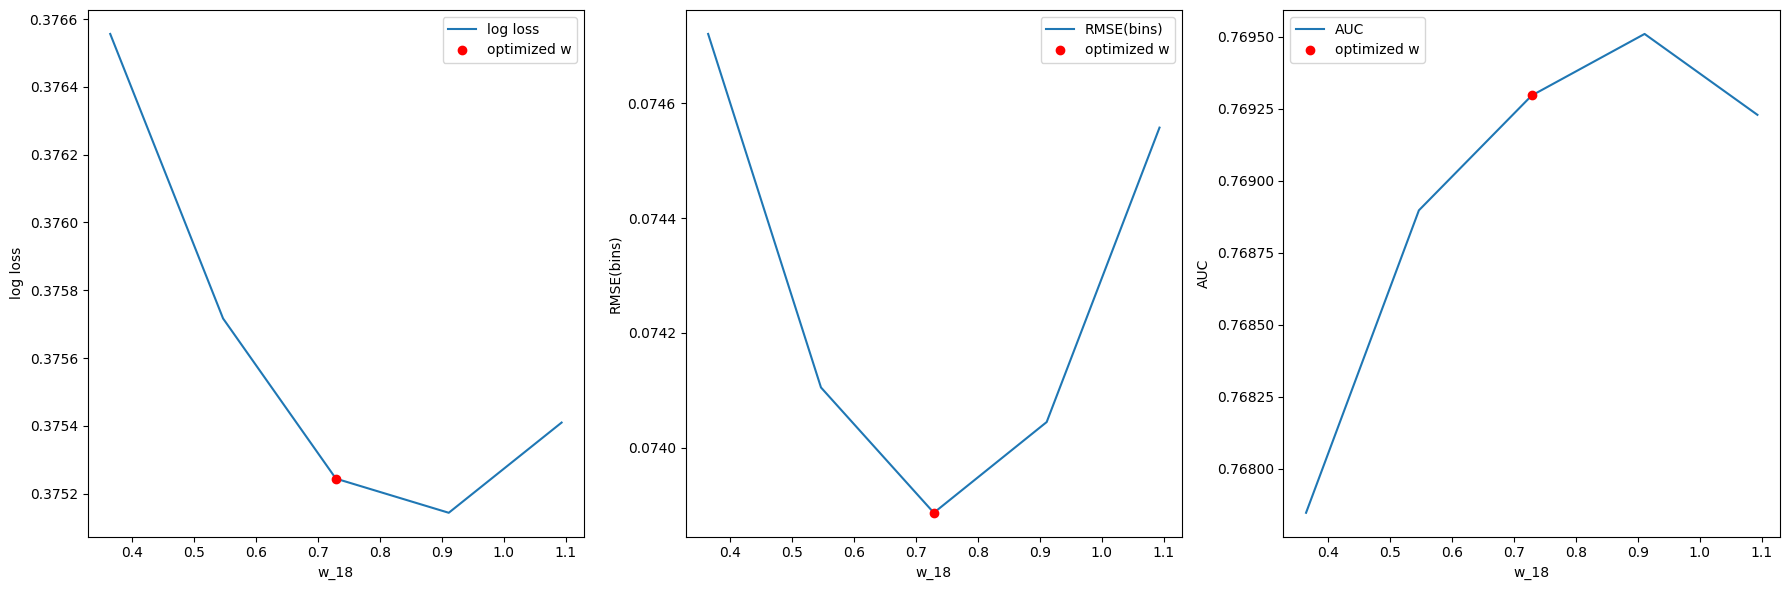

In [4]:
import numpy as np
import matplotlib.pyplot as plt

optimizer.w = optimized_w.copy()

for i, w in enumerate(optimizer.w):
    print(f"w_{i}: {w}")
    new_w_list = []
    log_loss_list = []
    rmse_list = []
    auc_list = []
    optimizer.w = optimized_w.copy()
    plt.close("all")
    for new_w in np.array([0.5, 0.75, 1, 1.25, 1.5]) * w:
        optimizer.w[i] = new_w
        _, loss_after = optimizer.evaluate(save_to_file=False)
        metrics, figures = optimizer.calibration_graph(verbose=False)
        for fig in figures:
            plt.close(fig)
        new_w_list.append(new_w)
        log_loss_list.append(loss_after)
        rmse_list.append(metrics["all"]["RMSE(bins)"])
        auc_list.append(metrics["all"]["AUC"])
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.plot(new_w_list, log_loss_list, label="log loss")
    # Add marker for w point
    plt.plot(w, log_loss_list[2], 'ro', label='optimized w')
    plt.xlabel(f"w_{i}")
    plt.ylabel("log loss")
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(new_w_list, rmse_list, label="RMSE(bins)")
    # Add marker for w point
    plt.plot(w, rmse_list[2], 'ro', label='optimized w')
    plt.xlabel(f"w_{i}")
    plt.ylabel("RMSE(bins)")
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(new_w_list, auc_list, label="AUC")
    # Add marker for w point
    plt.plot(w, auc_list[2], 'ro', label='optimized w')
    plt.xlabel(f"w_{i}")
    plt.ylabel("AUC")
    plt.legend()
    plt.tight_layout()
    plt.show()


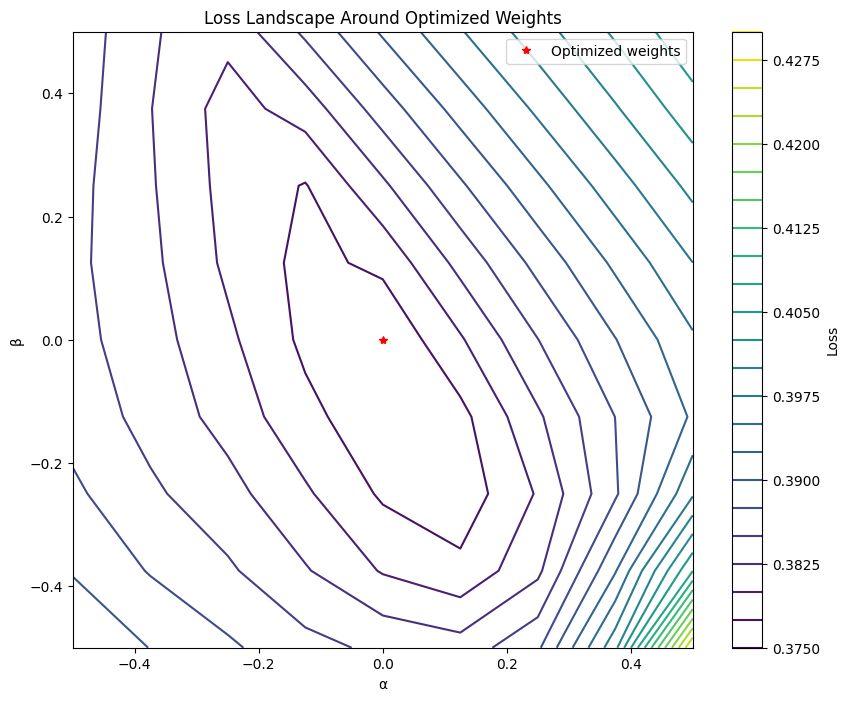

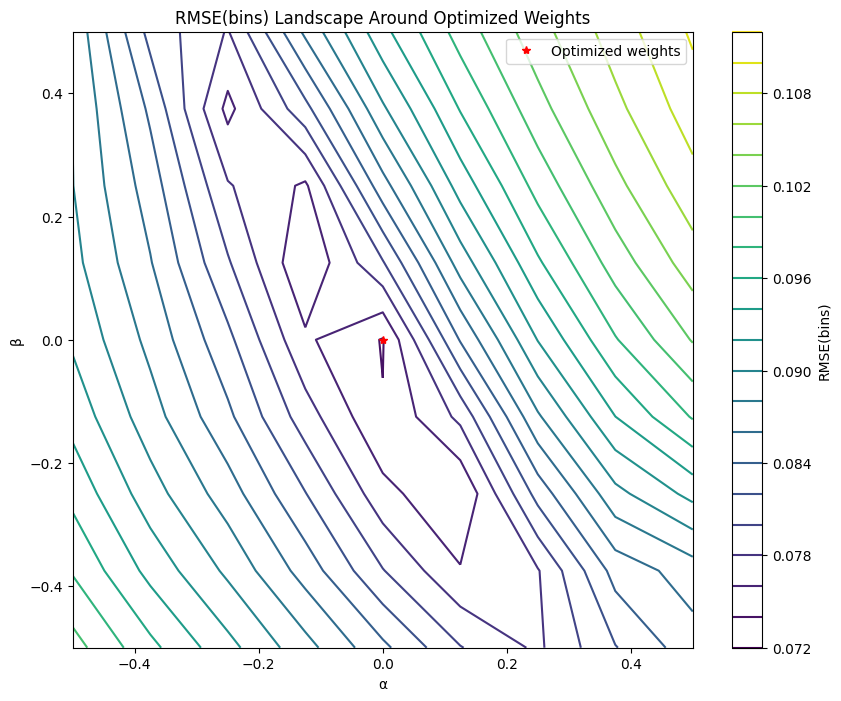

In [5]:
np.random.seed(2023)

# Reset weights back to optimized values
optimizer.w = optimized_w.copy()

# Choose two random direction vectors for visualization
delta = np.random.randn(len(optimizer.w))
eta = np.random.randn(len(optimizer.w))
# Normalize the direction vectors
delta = delta / np.linalg.norm(delta)
eta = eta / np.linalg.norm(eta)

# Create grid of alpha and beta values
alpha = np.linspace(-0.5, 0.5, 9)
beta = np.linspace(-0.5, 0.5, 9)
alpha_grid, beta_grid = np.meshgrid(alpha, beta)

# Initialize loss grid
loss_grid = np.zeros_like(alpha_grid)
rmse_grid = np.zeros_like(alpha_grid)

# Calculate loss for each point in the grid
for i in range(len(alpha)):
    for j in range(len(beta)):
        # Set weights to θ* + αδ + βη
        optimizer.w = optimized_w + alpha[i]*delta + beta[j]*eta
        _, loss = optimizer.evaluate(save_to_file=False)
        metrics, figures = optimizer.calibration_graph(verbose=False)
        for fig in figures:
            plt.close(fig)
        loss_grid[j,i] = loss
        rmse_grid[j,i] = metrics["all"]["RMSE(bins)"]

# Create contour plot
plt.figure(figsize=(10,8))
plt.contour(alpha_grid, beta_grid, loss_grid, levels=20)
plt.colorbar(label='Loss')
plt.plot(0, 0, 'r*', label='Optimized weights')
plt.xlabel('α')
plt.ylabel('β') 
plt.title('Loss Landscape Around Optimized Weights')
plt.legend()
plt.show()

plt.figure(figsize=(10,8))
plt.contour(alpha_grid, beta_grid, rmse_grid, levels=20)
plt.colorbar(label='RMSE(bins)')
plt.plot(0, 0, 'r*', label='Optimized weights')
plt.xlabel('α')
plt.ylabel('β') 
plt.title('RMSE(bins) Landscape Around Optimized Weights')
plt.legend()
plt.show()
